# torchmdn example

In [4]:
from pathlib import Path
from typing import Optional

import einops
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchmdn import mdn_likelihood_loss, sample_mdn
from tqdm import tqdm
%matplotlib inline

In [14]:
class MDN(torch.nn.Module):
    """
    Defines a Mixture Density Network block comprising of `n_mixtures` of Gaussians.

    Outputs pi, mu, sigma, where:
    + pi: mixture probability, sums to 1
    + mu: means of Gaussians
    + sigma: std dev of Gaussians
    """

    def __init__(
        self,
        in_features: int,
        n_mixtures: int,
        bias_init: Optional = None,
        device: Optional[str] = None,
        dtype: Optional = None,
    ):
        super().__init__()
        factory_kwargs = {"device": device, "dtype": dtype}
        self.w_pi = torch.nn.Linear(
            in_features=in_features,
            out_features=n_mixtures,
            bias=True,
            **factory_kwargs
        )
        self.w_mu = torch.nn.Linear(
            in_features=in_features,
            out_features=n_mixtures,
            bias=True,
            **factory_kwargs
        )

        if bias_init is not None:
            # ref: https://discuss.pytorch.org/t/fix-bias-and-weights-of-a-layer/75120/5
            with torch.no_grad():
                init_bias = torch.FloatTensor(bias_init, device=device)
                self.w_mu.bias = torch.nn.parameter.Parameter(
                    data=init_bias, requires_grad=True
                )
        else:
            pass

        self.w_sigma = torch.nn.Linear(
            in_features=in_features,
            out_features=n_mixtures,
            bias=True,
            **factory_kwargs
        )

    def forward(self, x):
        pi = self.w_pi(x)
        pi = torch.nn.functional.softmax(pi, dim=1)  # C of NC
        mu = self.w_mu(x)
        sigma = self.w_sigma(x)
        sigma = torch.exp(sigma)

        return pi, mu, sigma

In [15]:
def sample_fun(x):
    return (
        7 * np.sin(0.75 * x)
        + 0.5 * x
        + np.random.normal(loc=0, scale=1, size=np.squeeze(x).shape)
    )


ys = np.linspace(-10, 10, num=2000)
xs = np.apply_along_axis(sample_fun, axis=0, arr=ys)

We'll split the data into a training set and a testing set.

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2)

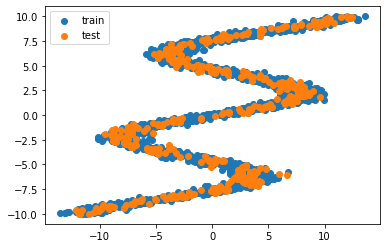

In [18]:
plt.scatter(X_train, y_train, label="train")
plt.scatter(X_test, y_test, label="test")
plt.legend()
plt.show()

In [19]:
X_train = einops.rearrange(X_train, "b -> b 1")
y_train = einops.rearrange(y_train, "b -> b 1")
X_test = einops.rearrange(X_test, "b -> b 1")
y_test = einops.rearrange(y_test, "b -> b 1")

In [20]:
X_train.shape, y_train.shape

((1600, 1), (1600, 1))

In [21]:
X_train_ten = torch.FloatTensor(X_train)
y_train_ten = torch.FloatTensor(y_train)
X_test_ten = torch.FloatTensor(X_test)
y_test_ten = torch.FloatTensor(y_test)

In [22]:
X_test_vec = X_test[:, 0]

## Model Architecture

In [24]:
class Net(torch.nn.Module):
    def __init__(self, n_mixtures, bias_init):
        super().__init__()
        self.mdn = MDN(in_features=1, n_mixtures=n_mixtures, bias_init=bias_init)

    def forward(self, x):
        out = self.mdn(x)
        return out

In [25]:
n_mixtures = 5

In [26]:
net = Net(n_mixtures=5, bias_init=[-7.5, -5, 1, 4, 8])

In [27]:
for i, j in net.named_parameters():
    print(i, j.shape)

mdn.w_pi.weight torch.Size([5, 1])
mdn.w_pi.bias torch.Size([5])
mdn.w_mu.weight torch.Size([5, 1])
mdn.w_mu.bias torch.Size([5])
mdn.w_sigma.weight torch.Size([5, 1])
mdn.w_sigma.bias torch.Size([5])


In [30]:
net.mdn.w_mu.bias

Parameter containing:
tensor([-7.5000, -5.0000,  1.0000,  4.0000,  8.0000], requires_grad=True)

In [58]:
net.mdn.w_mu.bias.shape == torch.FloatTensor(
    [-7.5000, -5.0000, 1.0000, 4.0000, 8.0000]
).shape

True

In [31]:
opt = torch.optim.Adam(net.parameters())

In [32]:
pi, mu, sigma = net(X_train_ten)
loss = mdn_likelihood_loss(torch.FloatTensor(y_train), pi, mu, sigma)

In [33]:
# Shape should be N, 5
pi.shape, mu.shape, sigma.shape

(torch.Size([1600, 5]), torch.Size([1600, 5]), torch.Size([1600, 5]))

In [34]:
# Should be just a number
loss

tensor(6.6977, grad_fn=<MeanBackward1>)

In [35]:
if not Path("ckpts").exists():
    Path("ckpts").mkdir()

In [36]:
losses = []
for i in tqdm(range(10000), ascii=True):
    opt.zero_grad()
    pi, mu, sigma = net(X_train_ten)
    loss = mdn_likelihood_loss(y_train_ten, pi, mu, sigma)
    loss.backward()
    opt.step()

    if i % 50 == 0:
        torch.save(net.state_dict(), f"ckpts/{i:04d}.ckpt")

    losses.append(loss.item())

100%|############################################################################| 10000/10000 [00:11<00:00, 859.27it/s]


Text(0, 0.5, 'Train loss')

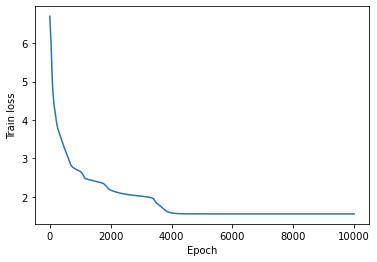

In [37]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Train loss")

## Visualizing outcome

Visualizing model output:

In [38]:
# This helps with plotting X_test in ascending order!
# X_test is scrambled from train_test_split earlier
sorted_idx = np.argsort(X_test_vec)

In [39]:
pi, mu, sigma = net(X_test_ten)
pi, mu, sigma = (
    pi.detach().numpy(),
    mu.detach().numpy(),
    sigma.detach().numpy(),
)

In [40]:
# Expected: ((400, 5), (400, 5), (400, 5), (400,))
pi.shape, mu.shape, sigma.shape, X_test.shape

((400, 5), (400, 5), (400, 5), (400, 1))

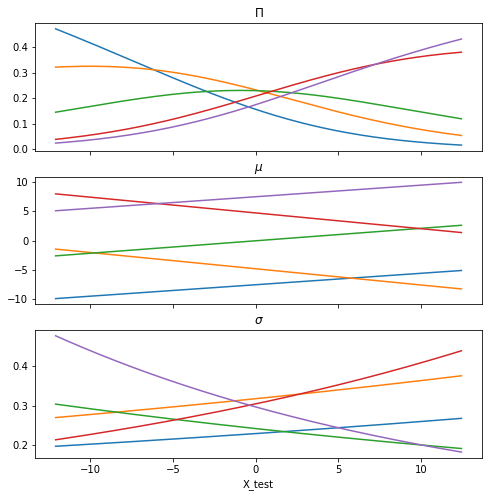

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8, 8))

for i in range(n_mixtures):
    ax1.plot(X_test_vec[sorted_idx], pi[:, i][sorted_idx])
    ax2.plot(X_test_vec[sorted_idx], mu[:, i][sorted_idx])
    ax3.plot(X_test_vec[sorted_idx], sigma[:, i][sorted_idx])

ax1.set_title("$\Pi$")
ax2.set_title("$\mu$")
ax3.set_title("$\sigma$")
plt.xlabel("X_test")
plt.show()

Visualizing the output of each distribution on top of test data:

In [42]:
X_test_vec.shape, mu.shape

((400,), (400, 5))

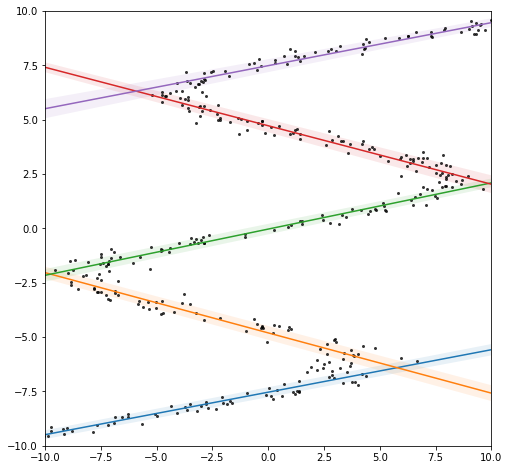

In [43]:
plt.figure(figsize=(8, 8), facecolor="white")

for i in range(n_mixtures):

    mu_k = mu[:, i][sorted_idx]
    sigma_k = sigma[:, i][sorted_idx]

    # Shade distribution as +/- sigma around mu
    plt.plot(X_test_vec[sorted_idx], mu_k)
    plt.fill_between(X_test_vec[sorted_idx], mu_k - sigma_k, mu_k + sigma_k, alpha=0.1)

plt.scatter(
    X_test_vec[sorted_idx], y_test[sorted_idx], marker=".", lw=0, alpha=0.8, c="black"
)
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.show()

Now let's extract historical weights and visualize how the distributions evolved to this point.

In [44]:
weight_files = sorted(Path().glob("ckpts/*.ckpt"))
wf_count = len(weight_files)

In [45]:
wf_count

200

In [46]:
hist_mus = np.zeros(shape=(X_test.shape[0], n_mixtures, wf_count))
hist_sigmas = np.zeros(shape=(X_test.shape[0], n_mixtures, wf_count))

In [47]:
for count, i in enumerate(weight_files):
    net.load_state_dict(torch.load(i))
    pi, mu, sigma = net(X_test_ten)
    hist_mus[:, :, count] = mu.detach().numpy()
    hist_sigmas[:, :, count] = sigma.detach().numpy()

In [48]:
hist_mus.shape, hist_sigmas.shape

((400, 5, 200), (400, 5, 200))

In [49]:
anim_path = Path("anim/")
if not anim_path.exists():
    anim_path.mkdir()

In [50]:
for count in tqdm(range(wf_count), ascii=True):
    out_mu = hist_mus[:, :, count]
    out_sigma = hist_sigmas[:, :, count]

    plt.figure(figsize=(8, 8), facecolor="white")

    for i in range(n_mixtures):

        mu_k = out_mu[:, i][sorted_idx]
        sigma_k = out_sigma[:, i][sorted_idx]

        # Shade distribution as +/- sigma around mu
        plt.plot(X_test_vec[sorted_idx], mu_k)
        plt.fill_between(
            X_test_vec[sorted_idx], mu_k - sigma_k, mu_k + sigma_k, alpha=0.1
        )

    plt.scatter(
        X_test_vec[sorted_idx],
        y_test[sorted_idx],
        marker=".",
        lw=0,
        alpha=0.8,
        c="black",
    )
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    plt.title("Mixture Distributions @ Epoch %02d" % ((count + 1) * 50))
    plt.savefig("anim/%03d.png" % count)
    plt.close()

100%|#################################################################################| 200/200 [00:17<00:00, 11.55it/s]


In [51]:
wf_count

200

In [52]:
# !convert anim/%03d.png[0-199] -delay 50 distributions_vs_epochs.gif
# Only need the first 3000 out of total 10000 epochs
!convert anim/%03d.png[0-79] -delay 50 distributions_vs_epochs.gif

In [53]:
from IPython.display import Image

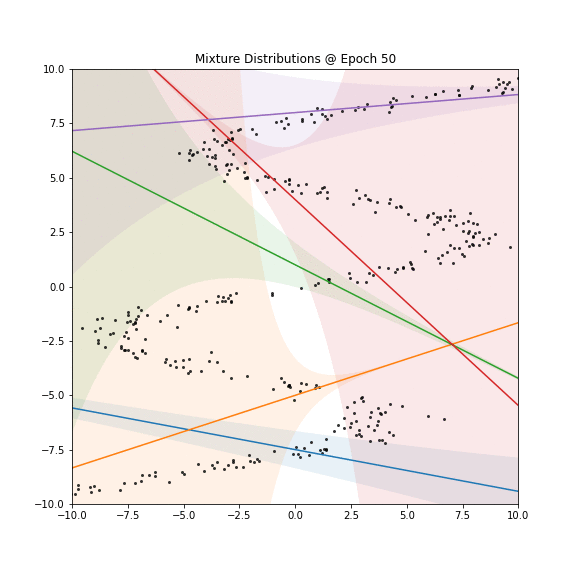

In [54]:
Image("distributions_vs_epochs.gif")